# Estudo e Caracterização de Filtro RC Passa-Banda

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from scipy.optimize import curve_fit

# import exp_physics as ep

In [4]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.dpi'] = 120
sns.set_theme()

## Funções e Constantes

In [5]:
def gain(w, w1, w2): return 1 / (np.sqrt(1 + (w1/w)**2) * np.sqrt(1 + (w/w2)**2))

In [6]:
R1, sR1 = 1000, 100
R2, sR2 = 4.67E3, 0.234E3
C1, sC1 = 0.47E-6, 0.047E-6
C2, sC2 = 10E-9, 1E-9
C3, sC3 = 1E-9, 0.1E-9

In [7]:
w1 = 1 / (2 * np.pi * R1 * C1)
w2 = 1 / (2 * np.pi * R2 * C2)
w3 = 1 / (2 * np.pi * R2 * C3)

In [8]:
w1, w2, w3

(338.62753849339435, 3408.0287599977587, 34080.287599977586)

## Filtro de 10 nF

In [9]:
df = pd.read_csv('dados/filtro_10nF.csv')

### Curva de Ganho

In [10]:
df['Inc. Ganho'] = 16*np.sqrt( (df['Inc. Tensão Saída (V)']/df['Tensão Entrada (V)'])**2 + (df['Inc. Tensão Entrada (V)']*df['Tensão Saída (V)']/df['Tensão Entrada (V)']**2)**2 )

In [11]:
popt, pcov = curve_fit(
	gain,
	xdata=df['Frequência (Hz)'],
	ydata=df['Ganho'],
	sigma=df['Inc. Ganho'],
	p0=( w1, w2 )
)

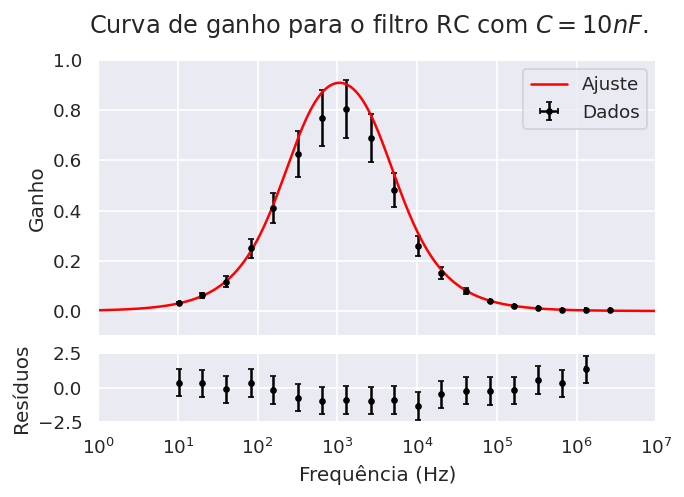

In [12]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={ 'hspace': 0.1, 'height_ratios': (4,1) })
plt.suptitle('Curva de ganho para o filtro RC com $C=10nF$.')

axs[0].errorbar(
	x=df['Frequência (Hz)'],
	y=df['Ganho'],
	xerr=df['Inc. Frequência (Hz)'],
	yerr=df['Inc. Ganho'],
	fmt=' ', marker='.', color='black', capsize=2, label='Dados'
)

x = np.logspace(0, 7, 1000)
sns.lineplot(x=x, y=gain(x, popt[0], popt[1]), color='red', ax=axs[0], label='Ajuste')

axs[1].errorbar(
	x=df['Frequência (Hz)'],
	y=(df['Ganho'] - gain(df['Frequência (Hz)'], popt[0], popt[1])) / df['Inc. Ganho'],
	xerr=df['Inc. Frequência (Hz)'],
	yerr=1,
	fmt=' ', marker='.', color='black', capsize=2
)

axs[0].set(ylabel='Ganho', ylim=(-0.1, 1))
axs[1].set(xlabel='Frequência (Hz)', ylabel='Resíduos', xscale='log', xlim=(1E0, 1E7), ylim=(-2.5, 2.5))
plt.savefig('plots/filter1_gain.png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
popt, np.sqrt(pcov)

(array([ 335.15466779, 3352.6315732 ]),
 array([[ 28.80390784,   6.38884248],
        [  6.38884248, 200.93125425]]))

In [14]:
w1, w2 = popt

In [15]:
chi2 = np.sum( (df['Ganho'] - gain(df['Frequência (Hz)'], popt[0], popt[1]))**2 / (df['Inc. Ganho'])**2 )
chi2

25.01202069638768

In [16]:
ngl = df.shape[0]
ngl

19

In [17]:
print(chi2 / ngl)

1.316422141915141


### Defasagem

In [18]:
df['Defasagem (°)'] = df['Fase Saída (º)'] - df['Fase Entrada (º)']
df['Inc. Fase (°)'] = 0.05 * 40

In [19]:
lag = df.dropna()

In [20]:
def phase(w, w1, w2): return np.degrees(np.arctan( (w1*w2 - w**2) / (w * (w1 + w2)) ))

In [21]:
popt, pcov = curve_fit(
	phase,
	xdata=lag['Frequência (Hz)'],
	ydata=lag['Fase Saída (º)'],
	p0=( w1, w2 )
)

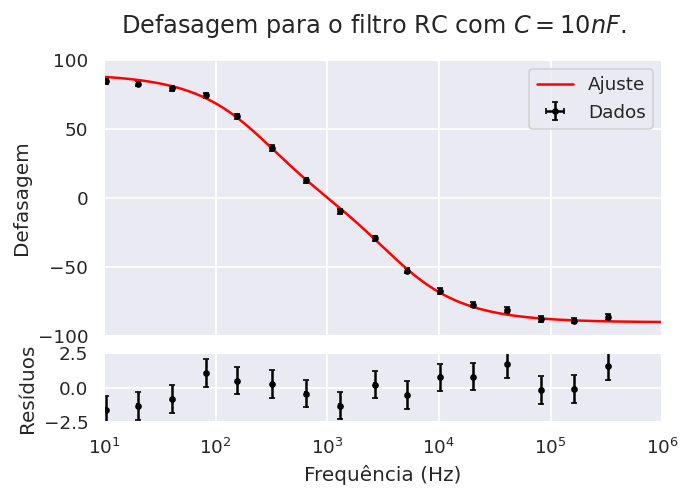

In [22]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={ 'hspace': 0.1, 'height_ratios': (4,1) })
plt.suptitle('Defasagem para o filtro RC com $C=10nF$.')

axs[0].errorbar(
	x=lag['Frequência (Hz)'],
	y=lag['Fase Saída (º)'],
	xerr=lag['Inc. Frequência (Hz)'],
	yerr=lag['Inc. Fase (°)'],
	fmt=' ', marker='.', color='black', capsize=2, label='Dados'
)

x = np.logspace(0, 7, 1000)
sns.lineplot(x=x, y=phase(x, popt[0], popt[1]), color='red', ax=axs[0], label='Ajuste')

axs[1].errorbar(
	x=lag['Frequência (Hz)'],
	y=(lag['Fase Saída (º)'] - phase(lag['Frequência (Hz)'], popt[0], popt[1])) / lag['Inc. Fase (°)'],
	xerr=lag['Inc. Frequência (Hz)'],
	yerr=1,
	fmt=' ', marker='.', color='black', capsize=2
)

axs[0].set(ylabel='Defasagem', ylim=(-100, 100))
axs[1].set(xlabel='Frequência (Hz)', ylabel='Resíduos', xscale='log', xlim=(1E1, 1E6), ylim=(-2.5, 2.5))
plt.savefig('plots/filter1_phase.png', dpi=300, bbox_inches='tight')
plt.show()

In [23]:
popt, np.sqrt(pcov)

/tmp/ipykernel_3527/2161760635.py:1: RuntimeWarning: invalid value encountered in sqrt
  popt, np.sqrt(pcov)


(array([ 276.48046944, 3697.61634681]),
 array([[ 12.87492338,          nan],
        [         nan, 171.3170535 ]]))

In [24]:
chi2 = np.sum( (df['Fase Saída (º)'] - phase(df['Frequência (Hz)'], popt[0], popt[1]))**2 / (df['Inc. Fase (°)'])**2 )
chi2

15.211304508196303

In [25]:
ngl = lag.shape[0]
ngl

16

In [26]:
df.to_csv('df1.csv')

## Filtro de 1 nF

### Ganho

In [27]:
df = pd.read_csv('dados/filtro_1nF.csv')

In [28]:
df['Inc. Ganho'] = 7.5*np.sqrt( (df['Inc. Tensão Saída (V)']/df['Tensão Entrada (V)'])**2 + (df['Inc. Tensão Entrada (V)']*df['Tensão Saída (V)']/df['Tensão Entrada (V)']**2)**2 )

In [29]:
df.to_csv('df2.csv')

In [27]:
popt, pcov = curve_fit(
	gain,
	xdata=df['Frequência (Hz)'],
	ydata=df['Ganho'],
	sigma=df['Inc. Ganho'],
	p0=( w1, w3 )
)

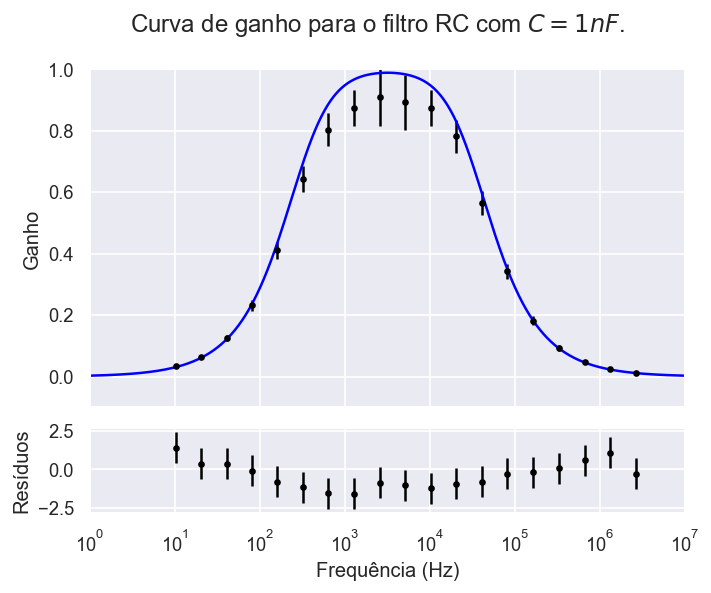

In [28]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={ 'hspace': 0.1, 'height_ratios': (4,1) })
plt.suptitle('Curva de ganho para o filtro RC com $C=1nF$.')

axs[0].errorbar(
	x=df['Frequência (Hz)'],
	y=df['Ganho'],
	xerr=df['Inc. Frequência (Hz)'],
	yerr=df['Inc. Ganho'],
	fmt=' ', marker='.', color='black'
)

x = np.logspace(0, 7, 1000)
sns.lineplot(x=x, y=gain(x, popt[0], popt[1]), color='blue', ax=axs[0])

axs[1].errorbar(
	x=df['Frequência (Hz)'],
	y=(df['Ganho'] - gain(df['Frequência (Hz)'], popt[0], popt[1])) / df['Inc. Ganho'],
	xerr=df['Inc. Frequência (Hz)'],
	yerr=1,
	fmt=' ', marker='.', color='black'
)

axs[0].set(ylabel='Ganho', ylim=(-0.1, 1))
axs[1].set(xlabel='Frequência (Hz)', ylabel='Resíduos', xscale='log', xlim=(1E0, 1E7))
plt.savefig('plots/filter2_gain.png', dpi=300, bbox_inches='tight')
plt.show()

In [29]:
ep.chisquare(df['Ganho'], gain(df['Frequência (Hz)'], popt[0], popt[1]), df['Inc. Ganho'], dof=len(df)-2)

0.9053971626510874

In [30]:
len(df)-2

17

In [31]:
ep.chisquare(df['Ganho'], gain(df['Frequência (Hz)'], popt[0], popt[1]), df['Inc. Ganho'])

15.391751765068484

In [32]:
popt

array([  332.48071321, 30420.43804929])

In [33]:
np.sqrt(pcov)

array([[ 10.44759561,   1.21488257],
       [  1.21488257, 865.74394949]])

### Defasagem

In [34]:
df['Defasagem (°)'] = df['Defasagem 1 (º)'] - df['Defasagem 2 (º)']
df['Inc. Fase (°)'] = 0.05 * 40

lag = df.dropna()

In [35]:
popt, pcov = curve_fit(
	phase,
	xdata=lag['Frequência (Hz)'],
	ydata=lag['Defasagem 2 (º)'],
	p0=( w1, w2 )
)

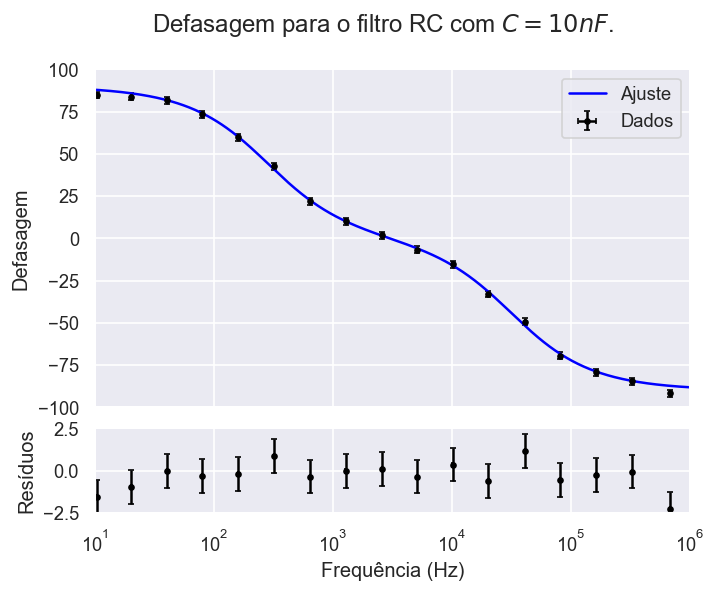

In [36]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={ 'hspace': 0.1, 'height_ratios': (4,1) })
plt.suptitle('Defasagem para o filtro RC com $C=10nF$.')

axs[0].errorbar(
	x=lag['Frequência (Hz)'],
	y=lag['Defasagem 2 (º)'],
	xerr=lag['Inc. Frequência (Hz)'],
	yerr=lag['Inc. Fase (°)'],
	fmt=' ', marker='.', color='black', capsize=2, label='Dados'
)

x = np.logspace(0, 7, 1000)
sns.lineplot(x=x, y=phase(x, popt[0], popt[1]), color='blue', ax=axs[0], label='Ajuste')

axs[1].errorbar(
	x=lag['Frequência (Hz)'],
	y=(lag['Defasagem 2 (º)'] - phase(lag['Frequência (Hz)'], popt[0], popt[1])) / lag['Inc. Fase (°)'],
	xerr=lag['Inc. Frequência (Hz)'],
	yerr=1,
	fmt=' ', marker='.', color='black', capsize=2
)

axs[0].set(ylabel='Defasagem', ylim=(-100, 100))
axs[1].set(xlabel='Frequência (Hz)', ylabel='Resíduos', xscale='log', xlim=(1E1, 1E6), ylim=(-2.5, 2.5))
plt.savefig('plots/filter2_phase.png', dpi=300, bbox_inches='tight')
plt.show()

In [37]:
ep.chisquare(lag['Defasagem 2 (º)'], phase(lag['Frequência (Hz)'], popt[0], popt[1]), lag['Inc. Fase (°)'], dof=len(lag)-2)

0.7930577485970551

In [38]:
len(lag)-2

15

In [39]:
ep.chisquare(lag['Defasagem 2 (º)'], phase(lag['Frequência (Hz)'], popt[0], popt[1]), lag['Inc. Fase (°)'])

11.895866228955828

In [40]:
popt

array([  282.42694402, 31927.48559469])

In [41]:
np.sqrt(pcov)

C:\Users\Marcus\AppData\Local\Temp\ipykernel_6988\3743271416.py:1: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(pcov)


array([[  10.37059946,           nan],
       [          nan, 1174.16391162]])